# Demonstration of Full ML Pipeline with a Materials Science Database

We will use Matminer to fetch materials datasets that are ML-ready (i.e., they largely don't require any data cleaning step). We will then consider two featurization approaches: compositional (using Matminer again) and structural (using DScribe). Then we will remove low variance features and highly correlated features with Pandas. Lastly, we use Scikit-Learn for data splitting, recursive feature elimintation, model performance metrics calculations, and ML model training (random forest model).

In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


### filter for oxygen-containing compounds. The OQMD API does not support "or" logic, so I cant just filter for metal oxides

In [33]:
url = "http://oqmd.org/oqmdapi/formationenergy"

all_entries = []
limit = 50  # max entries per request allowed by OQMD
offset = 0
max_entries = 1000

while len(all_entries) < max_entries:
    params = {
        "filter": "element_set=(O)",
        "limit": limit,
        "offset": offset
    }

    r = requests.get(url, params=params)
    data = r.json()

    batch = data.get("data", [])
    if not batch:
        break

    all_entries.extend(batch)
    offset += limit

    if len(all_entries) >= max_entries:
        # Stop if we have enough data
        all_entries = all_entries[:max_entries]
        break

print(f"Total entries retrieved: {len(all_entries)}")

for entry in all_entries[:1000]:  # print entries
    print(entry.get("name"))

#for entry in all_entries[:10]:  # print first 10 as example
#    print(entry.get("volume"), entry.get("band_gap"))

Total entries retrieved: 1000
ZnO
CuO
TiO
VO
BeO
MgO
MnO
NiO
ZnO
AgO
NiO
FeO
ZnO
AlO
NiO
CaO
PdO
SrO
SrO
PaO
BaO
TaO
O
ScO
YbO
BeO
CdO
NbO
NpO
PdO
GdO
PuO
NiO
BiO
ZrO
PtO
FeO
UO
SnO2
O
PrO
SmO
ZrO2
CrO
PdO
K2O
SrO2
Li2O
O
UO2
BaO2
Na2O
PuO2
LiO2
PaO2
Al2O
SiO2
TbO2
BaO2
Ag2O
Rb2O
HgO
CSO
KO2
RbO2
Cs2O
NpO2
PtO2
CsO2
NiO2
PbO2
CsO
NaCuO2
LiO3
AlCuO2
RbNdO2
GaCuO2
RbSmO2
FeCuO2
RbGdO2
YbAgO2
LiNiO2
PbO
NaNiO2
NaFeO2
NaCuO2
KPrO2
RbDyO2
RbHoO2
ReO3
NaNO2
RbEuO2
PtO
UO3
RbLaO2
CrCuO2
CaO
CdO
FeAgO2
CuO
MgO
SrCdO2
CuAgO2
LiCrO2
NaAlO2
CaO2
MnCuO2
CaFeO2
RbErO2
RbTmO2
RbYbO2
RbLuO2
NaCrO2
CaHgO2
NiAgO2
LiMoO2
BaHgO2
NaInO2
LiVO2
RbScO2
NaErO2
VBr2O
LuAgO2
InCuO2
AgRhO2
PbO
CaCuO2
ZnO
NiHO2
SnO
NaMnO2
CrAgO2
Sr2SO
UO3
PdO
BeO
LiAlO2
BaO
SrFeO2
LiGaO2
O
CdHgO2
BaSrO2
BaCaO2
WO3
MgO
SrCaO2
YCuO2
LiRhO2
NdNiO2
NiHO2
BaO
CuO
CsIO3
NaTaO3
NaTlO2
NaVO2
CuO2
ScBiO3
BaIrO3
KCrO2
SrVO3
LaAlO3
NdAlO3
VCl2O
Na3ClO
NaVO2
RbTlO2
NaTaO3
Li3BrO
BaPaO3
PrAlO3
KTaO3
K3BrO
CaTiO3
SrNbO3
ZrTaNO
SrCrO3
HfPbO3
Ba

In [34]:
# CHECK COMPOSITION TO SEE IF IT CONTAINS OXYGEN
for entry in all_entries[:1000]:  # print entries
    print(entry.get("composition"))

O1 Zn1
Cu1 O1
O1 Ti1
O1 V1
Be1 O1
Mg1 O1
Mn1 O1
Ni1 O1
O1 Zn1
Ag1 O1
Ni1 O1
Fe1 O1
O1 Zn1
Al1 O1
Ni1 O1
Ca1 O1
O1 Pd1
O1 Sr1
O1 Sr1
O1 Pa1
Ba1 O1
O1 Ta1
O1
O1 Sc1
O1 Yb1
Be1 O1
Cd1 O1
Nb1 O1
Np1 O1
O1 Pd1
Gd1 O1
O1 Pu1
Ni1 O1
Bi1 O1
O1 Zr1
O1 Pt1
Fe1 O1
O1 U1
O2 Sn1
O1
O1 Pr1
O1 Sm1
O2 Zr1
Cr1 O1
O1 Pd1
K2 O1
O2 Sr1
Li2 O1
O1
O2 U1
Ba1 O2
Na2 O1
O2 Pu1
Li1 O2
O2 Pa1
Al2 O1
O2 Si1
O2 Tb1
Ba1 O2
Ag2 O1
O1 Rb2
Hg1 O1
C1 O1 S1
K1 O2
O2 Rb1
Cs2 O1
Np1 O2
O2 Pt1
Cs1 O2
Ni1 O2
O2 Pb1
Cs1 O1
Cu1 Na1 O2
Li1 O3
Al1 Cu1 O2
Nd1 O2 Rb1
Cu1 Ga1 O2
O2 Rb1 Sm1
Cu1 Fe1 O2
Gd1 O2 Rb1
Ag1 O2 Yb1
Li1 Ni1 O2
O1 Pb1
Na1 Ni1 O2
Fe1 Na1 O2
Cu1 Na1 O2
K1 O2 Pr1
Dy1 O2 Rb1
Ho1 O2 Rb1
O3 Re1
N1 Na1 O2
Eu1 O2 Rb1
O1 Pt1
O3 U1
La1 O2 Rb1
Cr1 Cu1 O2
Ca1 O1
Cd1 O1
Ag1 Fe1 O2
Cu1 O1
Mg1 O1
Cd1 O2 Sr1
Ag1 Cu1 O2
Cr1 Li1 O2
Al1 Na1 O2
Ca1 O2
Cu1 Mn1 O2
Ca1 Fe1 O2
Er1 O2 Rb1
O2 Rb1 Tm1
O2 Rb1 Yb1
Lu1 O2 Rb1
Cr1 Na1 O2
Ca1 Hg1 O2
Ag1 Ni1 O2
Li1 Mo1 O2
Ba1 Hg1 O2
In1 Na1 O2
Li1 O2 V1
O2 Rb1 Sc1
Er1 Na1 O2
Br2 O1 V1
Ag1 Lu

In [35]:
#EXPORT TO PANDAS DATAFRAME
import pandas as pd

#records = data["all_entries"]
df = pd.DataFrame(all_entries)
print(df.head())

  name  entry_id  calculation_id  icsd_id  formationenergy_id  \
0  ZnO     20684            4500   163382             4061643   
1  CuO     11469            4561    61323             4061682   
2  TiO     17898            4752   105551             4061754   
3   VO      5578            5023    28681             4061871   
4  BeO     20737            5038   163820             4061895   

   duplicate_entry_id composition composition_generic prototype spacegroup  \
0              117131      O1 Zn1                  AB      CsCl      Pm-3m   
1               11469      Cu1 O1                  AB      NaCl      Fm-3m   
2               17898      O1 Ti1                  AB      NaCl      Fm-3m   
3                5578       O1 V1                  AB      NaCl      Fm-3m   
4               20737      Be1 O1                  AB  ZnS(cF8)      F-43m   

    volume  ntypes  natoms                                          unit_cell  \
0  18.8294       2       2  [[2.66039, 0.0, 0.0], [0.0, 2.6

In [36]:
# FILTER FOR METAL OXIDES, SINCE ORIGINAL QUERY IS ALL OXYGEN-CONTAINING COMPOUNDS
from pymatgen.core import Composition
from pymatgen.core.periodic_table import Element
import pandas as pd

# assume your dataframe is called df and has a column called "composition" 
# that contains chemical formulas like "Fe2O3", "Al2O3", "TiO2", etc.

def has_metal_and_oxygen(formula):
    comp = Composition(formula)

    # Check if any element is a metal
    for el in comp.elements:
        if Element(el).is_metal:
            return True

    return False

# Filter the dataframe
df_oxides = df[df["composition"].apply(has_metal_and_oxygen)].reset_index(drop=True)

print(df_oxides.head())
print("Number of metal oxides:", len(df_oxides))


  name  entry_id  calculation_id  icsd_id  formationenergy_id  \
0  ZnO     20684            4500   163382             4061643   
1  CuO     11469            4561    61323             4061682   
2  TiO     17898            4752   105551             4061754   
3   VO      5578            5023    28681             4061871   
4  BeO     20737            5038   163820             4061895   

   duplicate_entry_id composition composition_generic prototype spacegroup  \
0              117131      O1 Zn1                  AB      CsCl      Pm-3m   
1               11469      Cu1 O1                  AB      NaCl      Fm-3m   
2               17898      O1 Ti1                  AB      NaCl      Fm-3m   
3                5578       O1 V1                  AB      NaCl      Fm-3m   
4               20737      Be1 O1                  AB  ZnS(cF8)      F-43m   

    volume  ntypes  natoms                                          unit_cell  \
0  18.8294       2       2  [[2.66039, 0.0, 0.0], [0.0, 2.6

### Now I have a dataset of compounds that contain oxygen and 1 or more metal ions - **Metal Oxides!**

In [37]:
df_oxides.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,0.094227
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,0.263651
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,0.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,0.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,0.011308
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,0.064340
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,2.975383


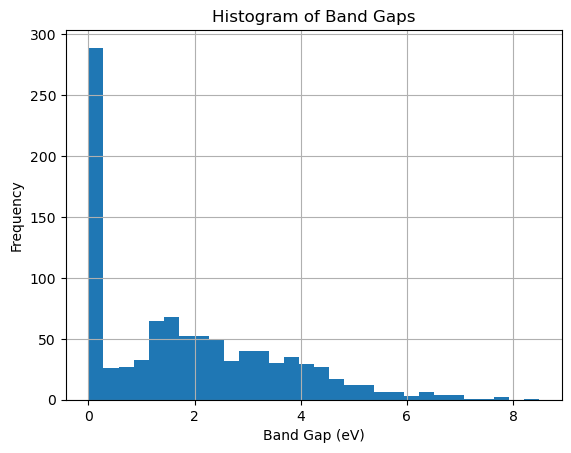

In [58]:
import matplotlib.pyplot as plt

df_oxides['band_gap'].hist(bins=30)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Band Gaps')
plt.show()

In [59]:
# copy dataframe
df_comp = df_oxides.copy()
df_comp.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,0.094227
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,0.263651
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,0.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,0.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,0.011308
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,0.064340
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,2.975383


### **Featurization**: OQMD uses strings to identify compisition, so we must convert them to a valid pymatgen composition. Then we weill featurize the compositions using the Matminer *ElementProperty* featurizer and use the magpie preset.

In [82]:
from pymatgen.core import Composition

df_comp["composition"] = df_comp["composition"].apply(Composition)

In [83]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition', ignore_errors=True) #SET IGNORE_ERRORS=TRUE, THIS MAY BE A MISTAKE

print(df_featurized.shape)  # type: ignore
print(df_featurized.isnull().sum().sum())  # Check for any NaN values  # type: ignore
#df_featurized.head()  # type: ignore
df_featurized.describe()  # type: ignore

/Users/coenradttaylor/opt/anaconda3/envs/chme6320/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/969 [00:00<?, ?it/s]

(969, 152)
153


,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,...,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,...,0.175184,0.042694,0.061779,0.000001,11.712074,212.788442,201.076367,101.011418,85.064827,28.637771
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,...,0.538180,0.139743,0.196175,0.000020,1.647898,33.766450,33.789430,32.687819,21.099564,56.107297
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,...,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,0.000000,11.500000,0.000000,2.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,...,0.000000,0.000000,0.000000,0.000000,12.000000,194.000000,182.000000,84.333333,73.920000,12.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,...,0.000000,0.000000,0.000000,0.000000,12.000000,225.000000,213.000000,100.500000,91.259259,12.000000
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,...,0.000000,0.000000,0.000000,0.000000,12.000000,229.000000,217.000000,119.500000,99.750000,12.000000
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,...,2.110663,1.055331,1.055331,0.000310,12.000000,229.000000,227.000000,201.333333,109.000000,229.000000


Number of features before cleaning: 150
Columns with very small variance: ['MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap', 'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom']
Number of features after removing small variance columns: 133
Columns to drop due to high correlation: {'MagpieData range Column', 'MagpieData maximum NdValence', 'MagpieData range NdValence', 'MagpieData range NfUnfilled', 'MagpieData avg_dev Number', 'MagpieData range GSbandgap', 'MagpieData maximum NpValence', 'MagpieData range SpaceGroupNumber', 'MagpieData range NsUnfilled', 'MagpieData mode Number', 'MagpieData range GSmagmom', 'MagpieData minimum AtomicWeight', 'MagpieData maximum NfValence', 'MagpieData range MendeleevNumber', 'MagpieData maximum SpaceGroupNumber', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum A

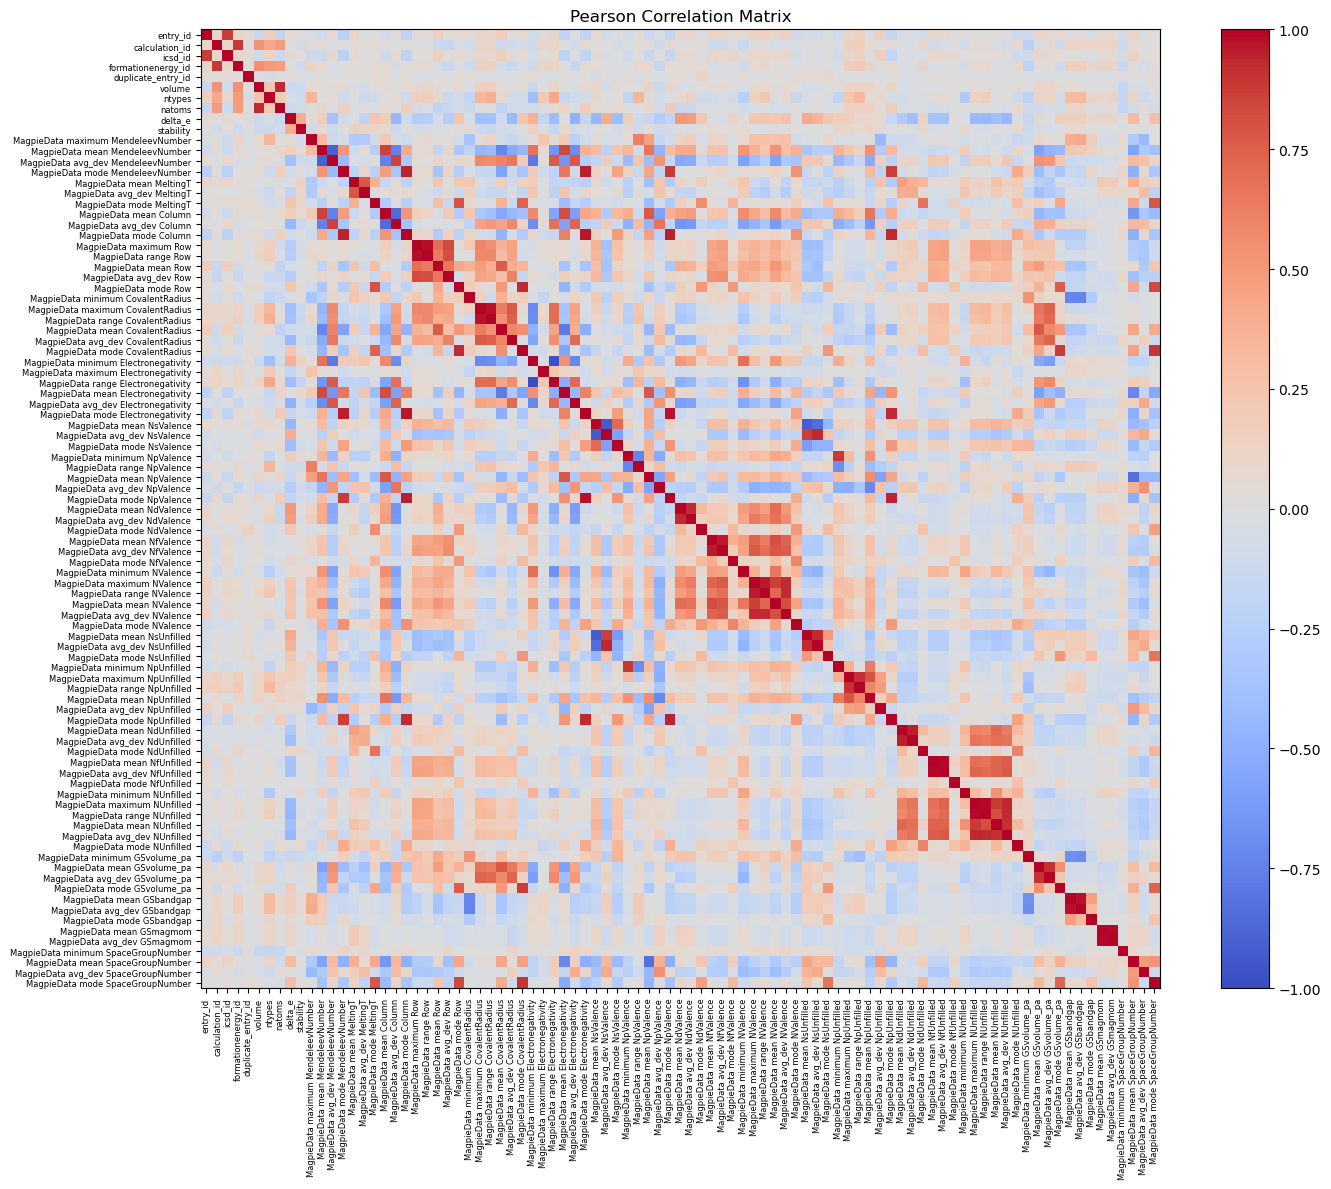

In [ ]:
y = df_featurized['band_gap']  # type: ignore
X_all = df_featurized.drop(columns=['band_gap', 'composition']) # type: ignore

print("Number of features before cleaning:", X_all.shape[1])

# Keep ONLY numeric columns
X_all = X_all.select_dtypes(include=['number'])

# Identify columns with very small variance and drop them
small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

# Remove highly correlated columns
threshold = 0.98 #SET IT TO 0.98, COULD SWITCH IT BACK TO 0.99 IF NEEDED
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

# For the remaining features, let's visualize the correlation matrix
corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.show()

### scale and split train/test

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")



Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


### Dummy model for baseline prediction

In [91]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting band gap): {baseline_mae:.4f} eV")

Baseline MAE (predicting band gap): 1.3480 eV


### **Hyperparameter optimization** Picking two values each for n_estimators, max_depth, max_features, and min_samples_split (omitting min_samples_leaf, bootstrap, criterion, due to computation time), for a total of 16 models. Will select best combination of hyperparameters

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# SELECTION OF HYPERPARAMETERS
param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [None, 20],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [2, 10],
}

# Generate all combinations
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"]
))
results = []

#Train each model
for (n_est, depth, max_feat, min_split) in tqdm(param_combinations, desc="Training 16 RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

import pandas as pd
results_df = pd.DataFrame(results)

#pick lowest MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 16 RF models:   0%|          | 0/16 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              500
max_depth                20.0
max_features              0.5
min_samples_split           2
train_mae             0.22842
val_mae              0.605254
Name: 14, dtype: object

Best Validation MAE: 0.6052542807280236


,n_estimators,max_depth,max_features,min_samples_split,train_mae,val_mae
14,500,20.0,0.5,2,0.228420,0.605254
10,500,NaN,0.5,2,0.228754,0.607630
6,100,20.0,0.5,2,0.231985,0.615436
2,100,NaN,0.5,2,0.232992,0.619873
15,500,20.0,0.5,10,0.341879,0.645777
11,500,NaN,0.5,10,0.341867,0.646043
7,100,20.0,0.5,10,0.345773,0.653929
3,100,NaN,0.5,10,0.345773,0.653929
4,100,20.0,sqrt,2,0.249953,0.669237
12,500,20.0,sqrt,2,0.246159,0.671473


RFE Progress:   0%|          | 0/18 [00:00<?, ?it/s]

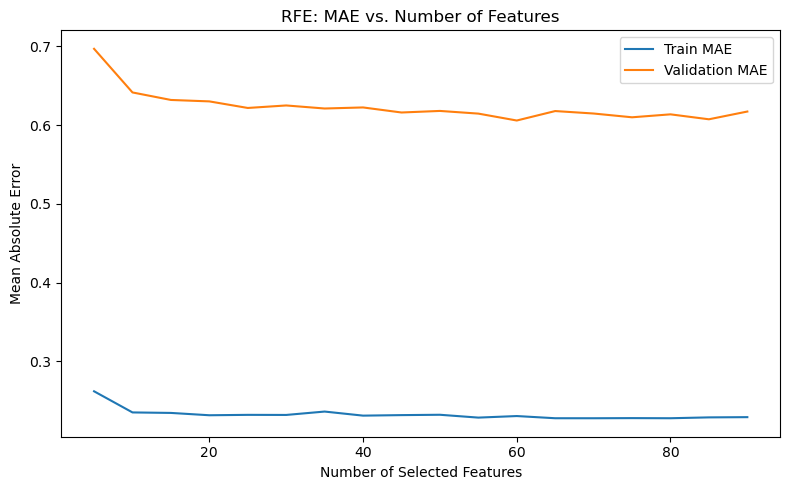

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=0.5, min_samples_split=2, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

### **Final model evalutation**: only need ~15 features to minimize MAE

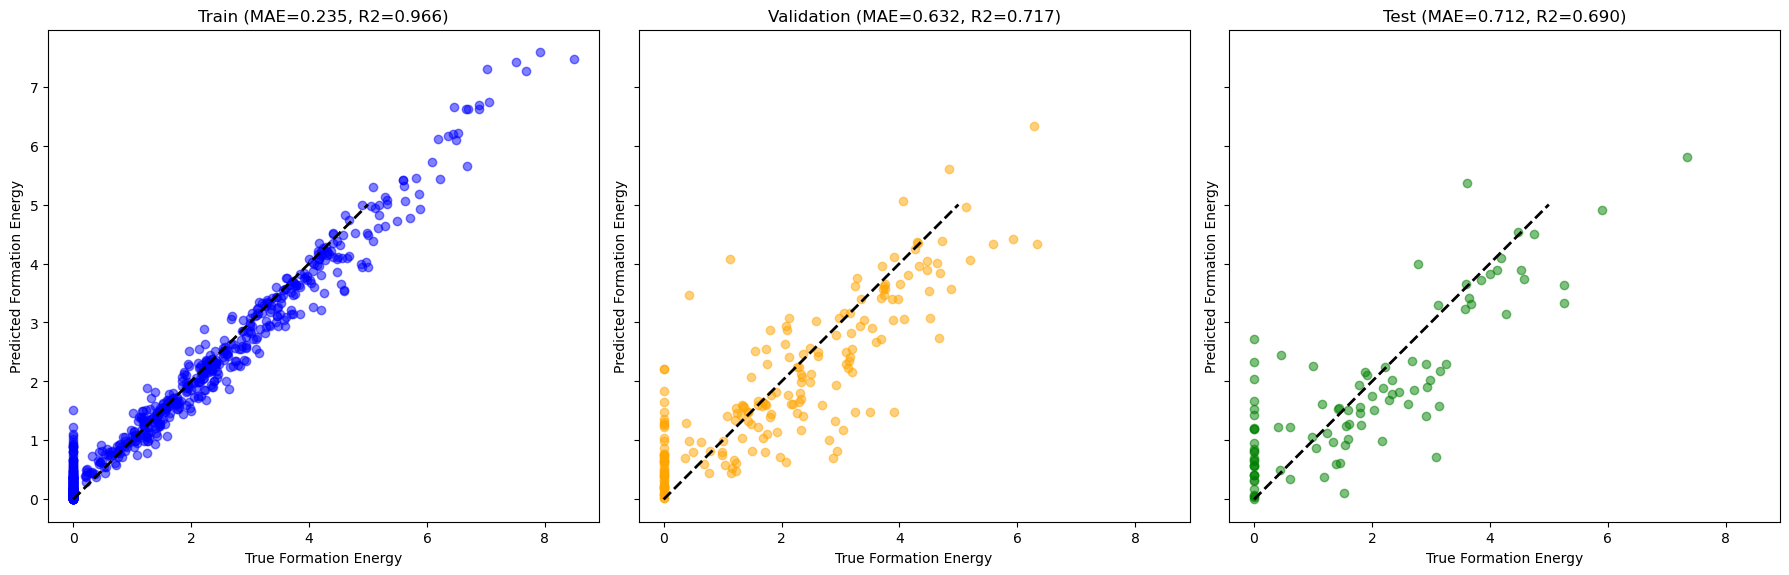

In [97]:
from sklearn.metrics import r2_score

final_features = selected_features_dict[15]
rf_final = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=0.5, min_samples_split=2, random_state=17, n_jobs=1)
X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

# Predict on train, validation, and test sets
X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val = 0.0
max_val = 5.0

# Train parity plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Formation Energy')
axes[0].set_ylabel('Predicted Formation Energy')
axes[0].set_aspect('equal', adjustable='box')

# Validation parity plot
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Formation Energy')
axes[1].set_ylabel('Predicted Formation Energy')
axes[1].set_aspect('equal', adjustable='box')

# Test parity plot
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Formation Energy')
axes[2].set_ylabel('Predicted Formation Energy')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [ ]:
from matminer.datasets.dataset_retrieval import load_dataset, get_all_dataset_info #idk
from matminer.datasets import get_available_datasets

print(*get_available_datasets(print_format='short'), sep='\n')

boltztrap_mp
brgoch_superhard_training
castelli_perovskites
citrine_thermal_conductivity
dielectric_constant
double_perovskites_gap
double_perovskites_gap_lumo
elastic_tensor_2015
expt_formation_enthalpy
expt_formation_enthalpy_kingsbury
expt_gap
expt_gap_kingsbury
flla
glass_binary
glass_binary_v2
glass_ternary_hipt
glass_ternary_landolt
heusler_magnetic
jarvis_dft_2d
jarvis_dft_3d
jarvis_ml_dft_training
m2ax
matbench_dielectric
matbench_expt_gap
matbench_expt_is_metal
matbench_glass
matbench_jdft2d
matbench_log_gvrh
matbench_log_kvrh
matbench_mp_e_form
matbench_mp_gap
matbench_mp_is_metal
matbench_perovskites
matbench_phonons
matbench_steels
mp_all_20181018
mp_nostruct_20181018
phonon_dielectric_mp
piezoelectric_tensor
ricci_boltztrap_mp_tabular
steel_strength
superconductivity2018
tholander_nitrides
ucsb_thermoelectrics
wolverton_oxides

boltztrap_mp
brgoch_superhard_training
castelli_perovskites
citrine_thermal_conductivity
dielectric_constant
double_perovskites_gap
double_perovski

For this demonstration let us work with the Matbench perovskite dataset which contains 18,928 DFT-calculated formation energies (in eV/unit cell).

In [ ]:
print(get_all_dataset_info('matbench_perovskites'))

Dataset: matbench_perovskites
Description: Matbench v0.1 test dataset for predicting formation energy from crystal structure. Adapted from an original dataset generated by Castelli et al. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	e_form: Target variable. Heat of formation of the entire 5-atom perovskite cell, in eV as calculated by RPBE GGA-DFT. Note the reference state for oxygen was computed from oxygen's chemical potential in water vapor, not as oxygen molecules, to reflect the application which these perovskites were studied for.
	structure: Pymatgen Structure of the material.
Num Entries: 18928
Reference: Ivano E. Castelli, David D. Landis, Kristian S. Thygesen, Søren Dahl, Ib Chorkendorff, Thomas F. Jaramillo and Karsten W. Jacobsen (2012) New cubic perovskites for one- and two-photon water splitting using the computational materials repo

In [ ]:
print(get_all_dataset_info('superconductivity2018'))

Dataset: superconductivity2018
Description: Dataset of ~16,000 experimental superconductivity records (critical temperatures) from Stanev et al., originally from the Japanese National Institute for Materials Science. Does not include structural data. Includes ~300 measurements from materials found without superconductivity (Tc=0). No modifications were made to the core dataset, aside from basic file type change to json for (un)packaging with matminer. Reproduced under the Creative Commons 4.0 license, which can be found here: http://creativecommons.org/licenses/by/4.0/.
Columns:
	composition: Chemical formula.
	Tc: Experimental superconducting temperature, in K.
Num Entries: 16414
Reference: https://doi.org/10.1038/s41524-018-0085-8
Bibtex citations: ['@article{Stanev2018,\n  doi = {10.1038/s41524-018-0085-8},\n  url = {https://doi.org/10.1038/s41524-018-0085-8},\n  year = {2018},\n  month = jun,\n  publisher = {Springer Science and Business Media {LLC}},\n  volume = {4},\n  number = {

## 1. Dataset Analysis

In [ ]:
import pandas as pd
df_full = load_dataset('matbench_perovskites')
#df_full = load_dataset('superconductivity2018')
df_full.describe()  # type: ignore

,e_form
count,18928.000000
mean,1.470932
std,0.742502
min,-0.640000
25%,0.960000
50%,1.360000
75%,1.840000
max,5.160000


For computational efficiency sake, we will randomly sample a smaller number of data points.

In [ ]:
n_sample = 2000
df = df_full.sample(n=2000, random_state=17)  # subsample for speed   # type: ignore
df.describe()

,e_form
count,2000.00000
mean,1.48705
std,0.75261
min,-0.14000
25%,0.98000
50%,1.38000
75%,1.84000
max,4.78000


Now, let us have a look at the distribution of the larget property `e_form`.

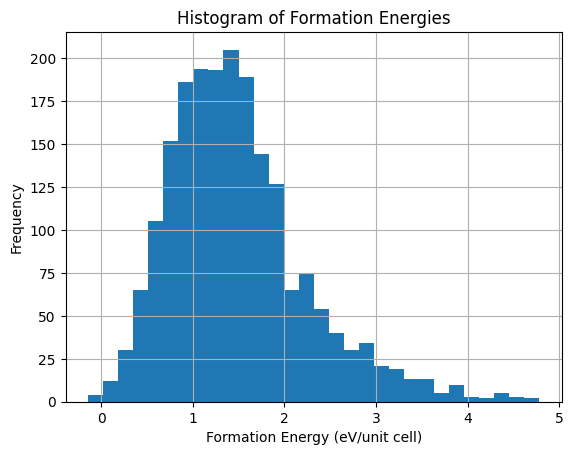

In [ ]:
import matplotlib.pyplot as plt

df['e_form'].hist(bins=30)
plt.xlabel('Formation Energy (eV/unit cell)')
plt.ylabel('Frequency')
plt.title('Histogram of Formation Energies')
plt.show()

## 2. Composition-based Features
First, let us add a new column that contains the composition of each entry through converting the Pymatgen structure to a composition.

In [ ]:
df_comp = df.copy()
df_comp['composition'] = df_comp.structure.apply(lambda x: x.composition )
df_comp.head()

,structure,e_form,composition
6376,"[[0.01612253 0. 0. ] Mo, [2.172...",1.26,"(Mo, Sb, F, O)"
6646,"[[0.00676393 0. 0. ] Al, [2.013...",0.96,"(Al, V, F, O)"
4235,"[[0.00074511 0. 0. ] Be, [1.867...",2.80,"(Be, Li, F, N, O)"
1855,[[9.23408500e-01 4.56669959e+00 7.49769700e-16...,1.82,"(Na, K, N, O)"
10984,[[8.30535692e-01 0.00000000e+00 6.38554198e-17...,1.84,"(Ni, Ca, N, O)"


### 2.1 Featurization
Then we will featurize the compositions using the Matminer `ElementProperty` featurizer and use the magpie preset.

In [ ]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition')

print(df_featurized.shape)  # type: ignore
print(df_featurized.isnull().sum().sum())  # Check for any NaN values  # type: ignore
df_featurized.head()  # type: ignore

/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 135)
0


,structure,e_form,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
6376,"[[0.01612253 0. 0. ] Mo, [2.172...",1.26,"(Mo, Sb, F, O)",8.0,51.0,43.0,23.6,18.32,8.0,50.0,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,86.8,88.56,12.0
6646,"[[0.00676393 0. 0. ] Al, [2.013...",0.96,"(Al, V, F, O)",8.0,23.0,15.0,12.2,4.64,8.0,46.0,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,98.6,102.72,12.0
4235,"[[0.00074511 0. 0. ] Be, [1.867...",2.80,"(Be, Li, F, N, O)",3.0,9.0,6.0,6.2,2.16,3.0,1.0,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,128.8,92.24,12.0
1855,[[9.23408500e-01 4.56669959e+00 7.49769700e-16...,1.82,"(Na, K, N, O)",7.0,19.0,12.0,10.6,3.52,8.0,2.0,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,135.2,98.56,12.0
10984,[[8.30535692e-01 0.00000000e+00 6.38554198e-17...,1.84,"(Ni, Ca, N, O)",7.0,28.0,21.0,14.0,8.00,7.0,7.0,...,0.595395,0.119079,0.190526,0.0,12.0,225.0,213.0,170.0,63.20,194.0


### 2.2 Feature Engineering and Cleaning
We store the target column is `"e_form"` in variable `y`, and the features in `X_all`.

We remove all features with very small variance and features that highly correlate with other features in the dataset.

Number of features before cleaning: 132
Columns with very small variance: ['MagpieData minimum Row', 'MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData mode NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData mode NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData mode NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData maximum NfUnfilled', 'MagpieData range NfUnfilled', 'MagpieData mean NfUnfilled', 'MagpieData avg_dev NfUnfilled', 'MagpieData mode NfUnfilled', 'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom']
Number of features after removing small variance columns: 115
Columns to drop due to high correlation: {'MagpieData maximum Number', 'MagpieData maximum NfValence', 'MagpieData maximum GSbandgap', 'MagpieData maximum GSvolume_pa', 'MagpieData maximum NdValence', 'MagpieData range MendeleevNumber', 'MagpieData range GSmagmom', 'MagpieData mean Number', 'MagpieData range Number', 'MagpieData maximu

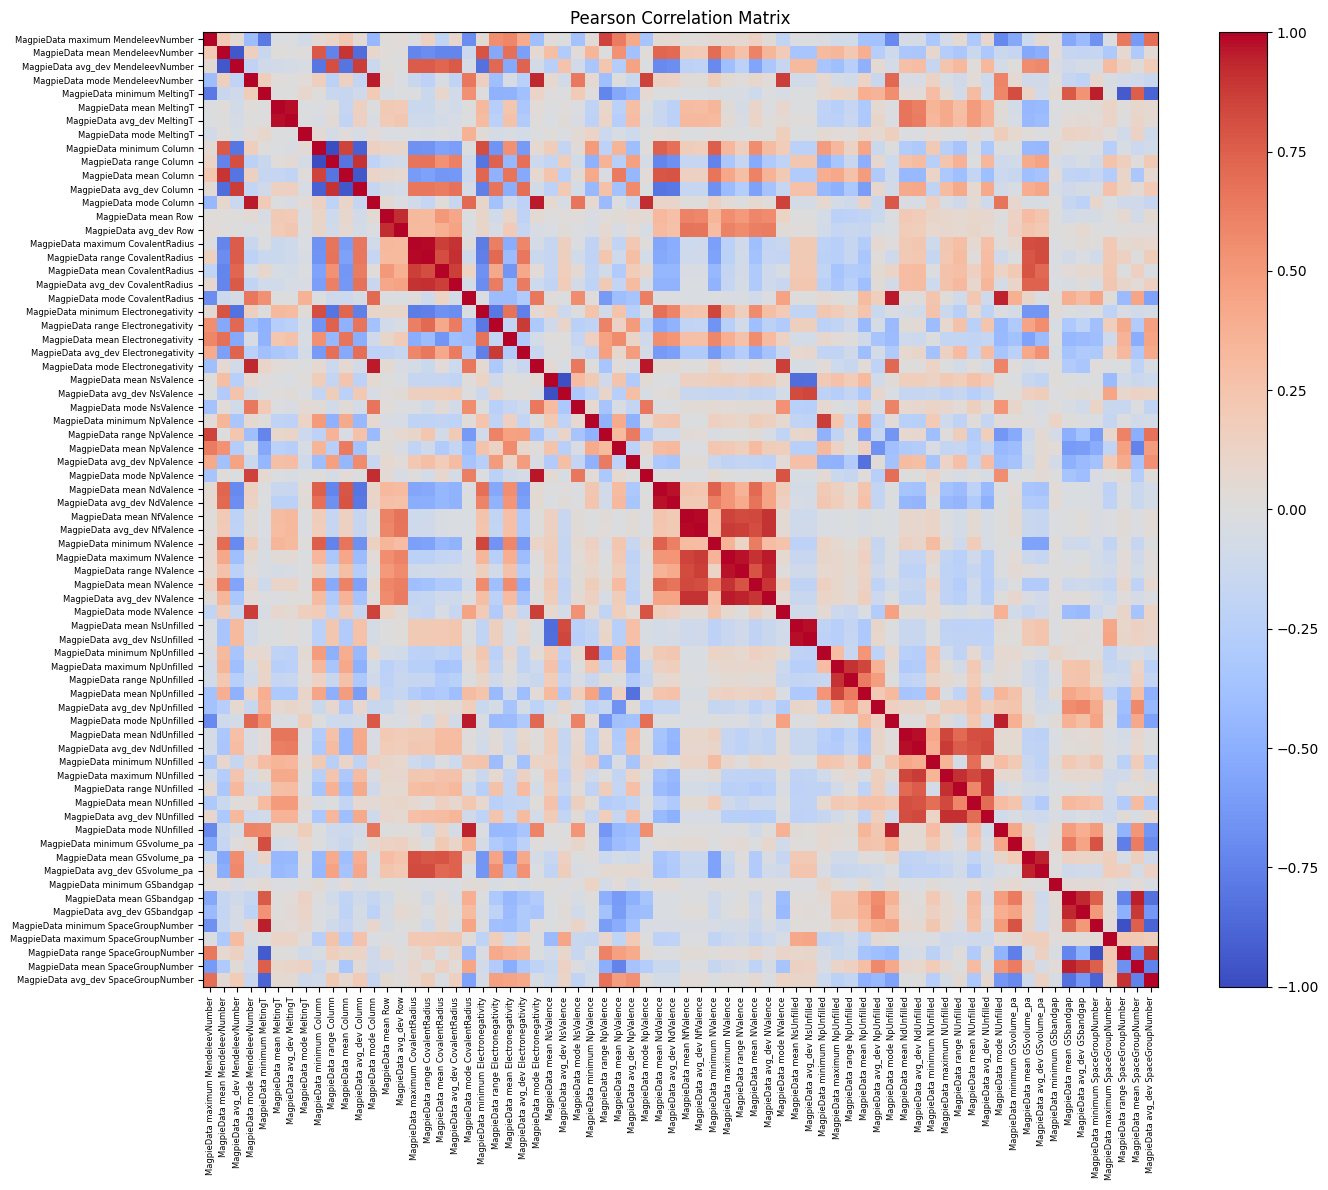

In [ ]:
y = df_featurized['e_form']  # type: ignore
X_all = df_featurized.drop(columns=['e_form', 'structure', 'composition'])  # type: ignore

print("Number of features before cleaning:", X_all.shape[1])

# Identify columns with very small variance and drop them
small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

# Remove highly correlated columns
threshold = 0.99
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

# For the remaining features, let's visualize the correlation matrix
corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.show()

### 2.3 Feature Scaling and Dataset Splitting
Now we use the `StandardScaler` of the Scikit-Learn package, which is always advisable for all input features as it improves numeric stability during model optimization (e.g., gradient descent).

Then we split the dataset into training, validation, and test sets.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")



Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


### 2.4 Dummy Baseline Model

We will compute the MAE for a dummy baseline model, which always predicts the average of the training set target value for all validation predictions. This is used as a reference to compare how well the model learns compared to a very naive "model".

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))

print(f"Baseline MAE (predicting mean formation energy): {baseline_mae:.4f} eV")

Baseline MAE (predicting mean formation energy): 0.5553 eV


### 2.5 Hyperparameter Optimization

Here, we will choose the `RandomForestRegressor` of Scikit-Learn which has a few hyperparameters. We will optimize only one here for demonstration purposes: `n_estimators`.



Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

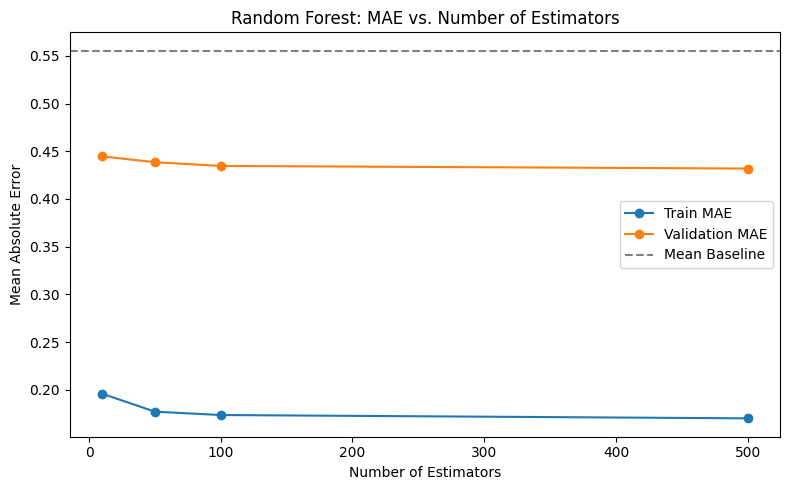

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.show()

### 2.6 Recursive Feature Elimintation

Now we use the RF model to further downselect important features by using the `RFE` class of Scikit-Learn.

*Remark*: This step can get quite compute-intensive! Here, we check RFE in steps of 5 features. Ideally, this should be carried out in steps of 1.

RFE Progress:   0%|          | 0/14 [00:00<?, ?it/s]

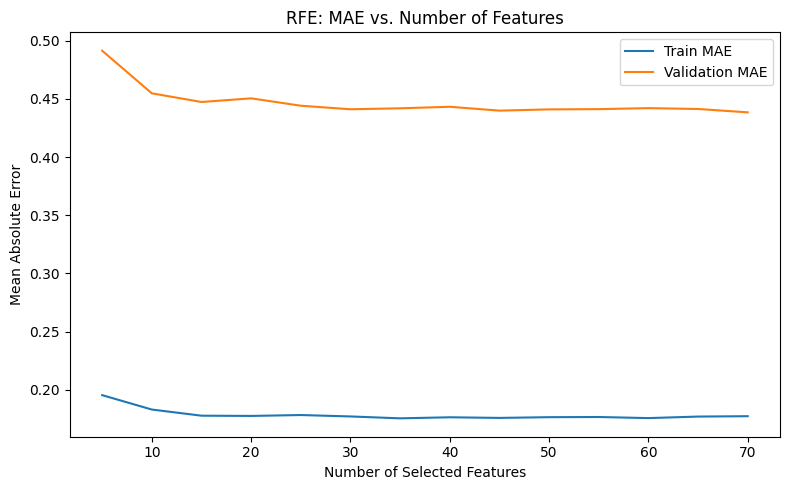

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=50, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

### 2.7 Final Model Evaluation
Lastly, we compute all train/validation/test metrics (here we look at MAE and R^2, but this can be easily extended to RMSE, MAPE, etc.). We also create parity plots (true vs. predicted target values) for all three sets.

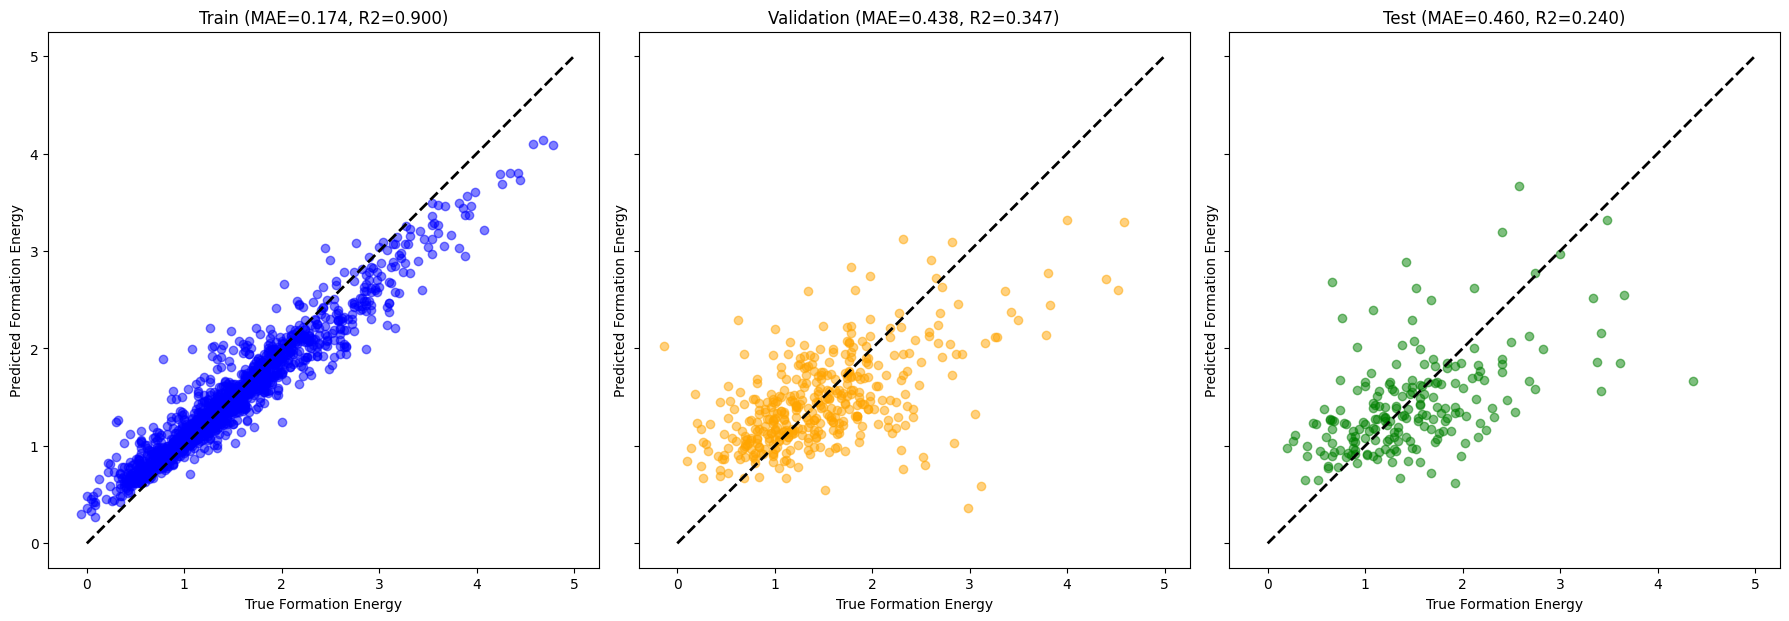

In [ ]:
from sklearn.metrics import r2_score

final_features = selected_features_dict[30]
rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

# Predict on train, validation, and test sets
X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val = 0.0
max_val = 5.0

# Train parity plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Formation Energy')
axes[0].set_ylabel('Predicted Formation Energy')
axes[0].set_aspect('equal', adjustable='box')

# Validation parity plot
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Formation Energy')
axes[1].set_ylabel('Predicted Formation Energy')
axes[1].set_aspect('equal', adjustable='box')

# Test parity plot
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Formation Energy')
axes[2].set_ylabel('Predicted Formation Energy')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## 3. Structure-based Features

Now, let us use the same steps but instead of using compositional featurization, we will use a strucutral one (the Ewald sum matrix approach via the DScribe package).

### 3.1 Featurization

In [ ]:
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np

# Determine the maximum number of atoms across all structures in the dataset
n_max = 0
for mat in df['structure']:
    if len(mat) > n_max :
        n_max = len(mat)
print(n_max)

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")

ase_structures = [AseAtomsAdaptor.get_atoms(struc) for struc in df['structure']]
ews_matrices = np.array(ews.create(ase_structures))

5


In [ ]:
ews_columns = [f'ews_{i}' for i in range(ews_matrices.shape[1])]
df_featurized_ews = df.copy()
df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
print(df_featurized_ews.head())

                                               structure  e_form        ews_0  \
6376   [[0.01612253 0.         0.        ] Mo, [2.172...    1.26 -1137.914679   
6646   [[0.00676393 0.         0.        ] Al, [2.013...    0.96  -213.103055   
4235   [[0.00074511 0.         0.        ] Be, [1.867...    2.80   -48.021356   
1855   [[9.23408500e-01 4.56669959e+00 7.49769700e-16...    1.82  -133.006466   
10984  [[8.30535692e-01 0.00000000e+00 6.38554198e-17...    1.84  -347.107219   

            ews_1      ews_2      ews_3      ews_4  
6376  -307.309683 -26.521014 -14.165220 -12.356065  
6646   -62.454371 -17.668754 -14.931351 -13.372305  
4235   -16.310810 -12.188321  -6.173471  -1.471585  
1855   -32.373734 -20.434960 -10.012023  -8.891698  
10984  -88.816129 -21.069402 -12.544796 -10.295272  


### 3.2 Feature Engineering and Cleaning

Number of features before cleaning: 5
Columns with very small variance: []
Number of features after removing small variance columns: 5
Columns to drop due to high correlation: set()
Number of features after removing highly correlated columns: 5


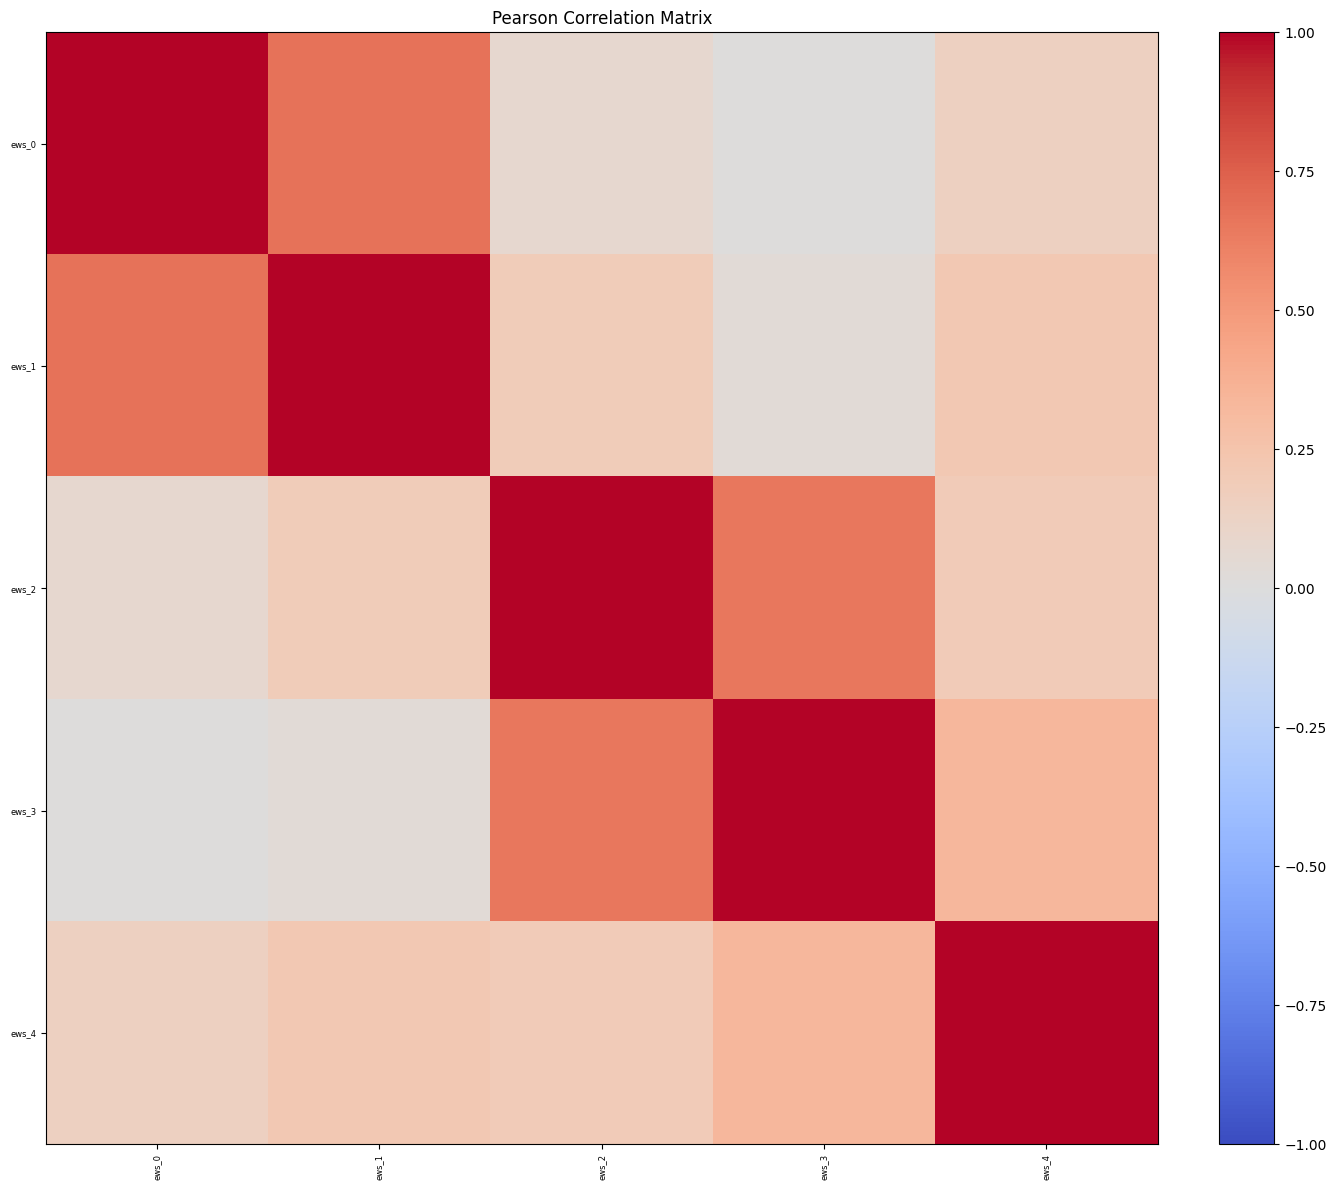

In [ ]:
y = df_featurized_ews['e_form']
X_all_struc = df_featurized_ews.drop(columns=['e_form', 'structure'])

print("Number of features before cleaning:", X_all_struc.shape[1])

# Identify columns with very small variance and drop them
small_var_cols_struc = X_all_struc.columns[X_all_struc.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols_struc)
X_all_struc = X_all_struc.drop(columns=small_var_cols_struc)
corr_matrix_struc = X_all_struc.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all_struc.shape[1])

# Remove highly correlated columns
threshold = 0.99
to_drop_struc = set()
for col in corr_matrix_struc.columns:
    high_corr_struc = corr_matrix_struc.index[(corr_matrix_struc[col].abs() > threshold) & (corr_matrix_struc.index != col)]
    to_drop_struc.update(high_corr_struc)
print("Columns to drop due to high correlation:", to_drop_struc)
X_struc = X_all_struc.drop(columns=list(to_drop_struc))
print("Number of features after removing highly correlated columns:", X_struc.shape[1])

corr_matrix_struc = X_struc.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix_struc, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], fontsize=6)
plt.tight_layout()
plt.show()

### 3.3 Feature Scaling and Dataset Splitting

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


### 3.4 Dummy Baseline Model

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting mean formation energy): {baseline_mae:.4f} eV")

Baseline MAE (predicting mean formation energy): 0.5553 eV


### 3.5 Hyperparameter Optimization

Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

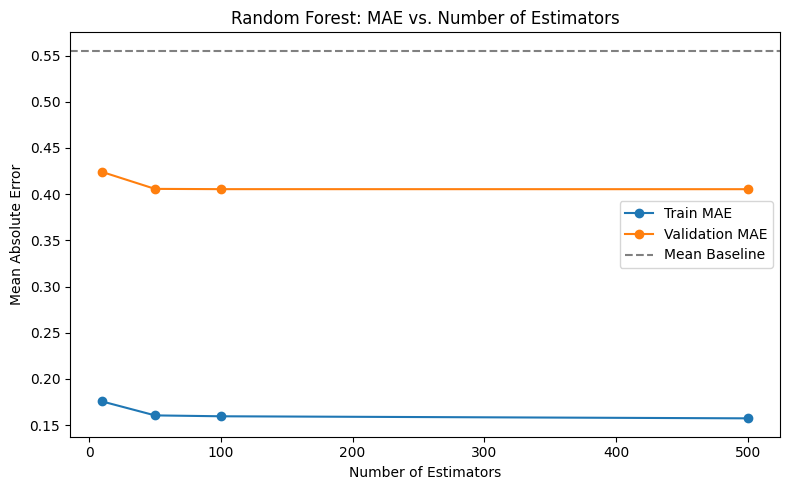

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.show()

### 2.6 Recursive Feature Elimintation
Technically, this step is not required because we already start off with a low number of features to begin with.

RFE Progress:   0%|          | 0/5 [00:00<?, ?it/s]

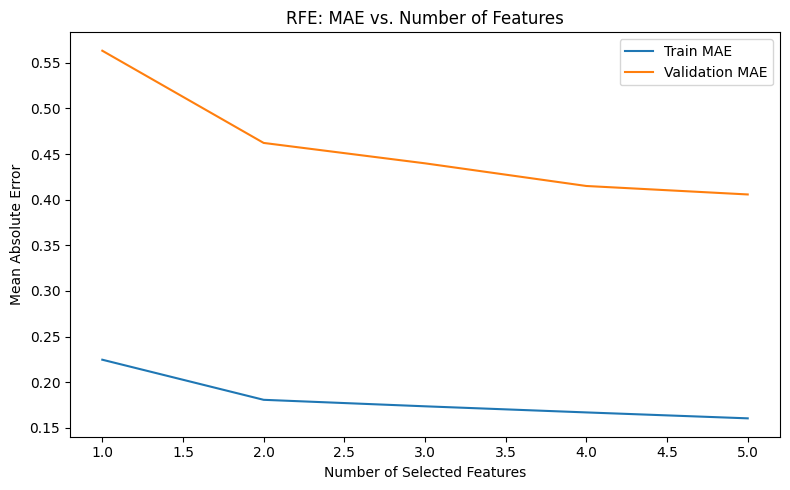

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=50, random_state=17, n_jobs=1)
n_features_list = list(range(1, X_val.shape[1]+1, 1))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=1)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X_struc.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

### 3.7 Final Model Evaluation

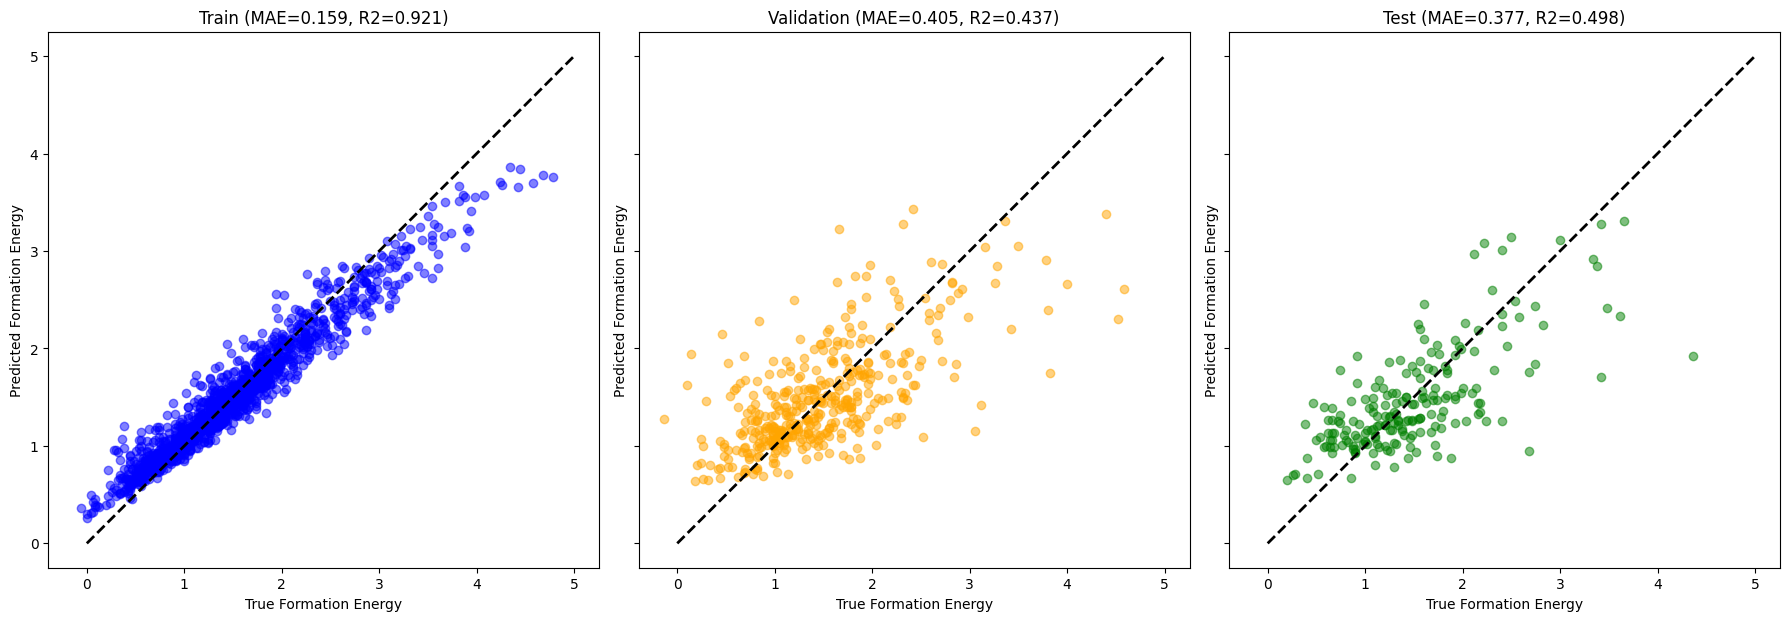

In [ ]:
from sklearn.metrics import r2_score

rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
rf_final.fit(X_train, y_train)

y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
min_val = 0.0
max_val = 5.0

# Train parity plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title(f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})')
axes[0].set_xlabel('True Formation Energy')
axes[0].set_ylabel('Predicted Formation Energy')
axes[0].set_aspect('equal', adjustable='box')

# Validation parity plot
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_title(f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})')
axes[1].set_xlabel('True Formation Energy')
axes[1].set_ylabel('Predicted Formation Energy')
axes[1].set_aspect('equal', adjustable='box')

# Test parity plot
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_title(f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})')
axes[2].set_xlabel('True Formation Energy')
axes[2].set_ylabel('Predicted Formation Energy')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

**Conclusion**: 5 structural features outperformed 100+ compositional features! 

There is still for improvement though. Top compositional features could be added to the 5 structural features. Alternatively, more sophisticated approaches (graph-based) may perform better here.

## 4. Exercise 11.1 → Homework 4

Now, it's your turn to utilize this entire pipeline on a different Matminer dataset! However, notice that some datasets only have compositions available and not the structures. Do it twice, once for a compositional featurization and once for a structural one (or, if your dataset does not contain structures, use a second compositional featurization approach).

Please, fill in the details in this [Google Sheet](https://docs.google.com/spreadsheets/d/1xbT4lRMYQGrhBQGFczFD5wscrriwWQGf82Gv9AnDkbA/4).

In [ ]:
# List of available datasets:
from matminer.datasets import get_available_datasets

print(*get_available_datasets(print_format='short'), sep='\n')

boltztrap_mp
brgoch_superhard_training
castelli_perovskites
citrine_thermal_conductivity
dielectric_constant
double_perovskites_gap
double_perovskites_gap_lumo
elastic_tensor_2015
expt_formation_enthalpy
expt_formation_enthalpy_kingsbury
expt_gap
expt_gap_kingsbury
flla
glass_binary
glass_binary_v2
glass_ternary_hipt
glass_ternary_landolt
heusler_magnetic
jarvis_dft_2d
jarvis_dft_3d
jarvis_ml_dft_training
m2ax
matbench_dielectric
matbench_expt_gap
matbench_expt_is_metal
matbench_glass
matbench_jdft2d
matbench_log_gvrh
matbench_log_kvrh
matbench_mp_e_form
matbench_mp_gap
matbench_mp_is_metal
matbench_perovskites
matbench_phonons
matbench_steels
mp_all_20181018
mp_nostruct_20181018
phonon_dielectric_mp
piezoelectric_tensor
ricci_boltztrap_mp_tabular
steel_strength
superconductivity2018
tholander_nitrides
ucsb_thermoelectrics
wolverton_oxides

boltztrap_mp
brgoch_superhard_training
castelli_perovskites
citrine_thermal_conductivity
dielectric_constant
double_perovskites_gap
double_perovski

List of available Matminer datasets: [link](https://hackingmaterials.lbl.gov/matminer/dataset_summary.html)

List of available Matminer featurizers: [link](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html)

List of available DScribe featurizers: [link](https://singroup.github.io/dscribe/latest/)